# Q-Learning vs. Meta-Learning: A Comparison

This notebook implements a standard **Q-learning agent** to solve a single maze task. The primary goal is to compare its performance and adaptability against the **MAML (Meta-Learning) agent** from the previous notebook.

We will demonstrate:
1.  How to train a specialist Q-learning agent to master one task.
2.  The Q-learning agent's high performance on its trained task.
3.  The Q-learning agent's inability to adapt to a new, unseen task.
4.  How this highlights the key advantage of meta-learning: the ability to generalize and adapt quickly.

## 1. Installation and Imports

In [1]:
!pip install -q numpy matplotlib

import numpy as np
import random
import matplotlib.pyplot as plt


## 2. The Gridworld Environment

For a fair comparison, we use the **exact same** `GridWorldEnv` class from the MAML notebook, including the reward shaping.

In [2]:
class GridWorldEnv:
    def __init__(self, size=5):
        self.size = size
        self.action_space = [0, 1, 2, 3] # 0:Up, 1:Down, 2:Left, 3:Right
        self.state = (0, 0)
        self.goal = (size - 1, size - 1)

    def set_goal(self, goal_pos):
        self.goal = goal_pos

    def reset(self):
        self.state = (0, 0)
        return self.state

    def step(self, action):
        x, y = self.state
        gx, gy = self.goal
        dist_before = abs(x - gx) + abs(y - gy)

        if action == 0: y = min(self.size - 1, y + 1)
        elif action == 1: y = max(0, y - 1)
        elif action == 2: x = max(0, x - 1)
        elif action == 3: x = min(self.size - 1, x + 1)

        self.state = (x, y)
        dist_after = abs(x - gx) + abs(y - gy)

        done = (self.state == self.goal)
        if done:
            reward = 10.0
        else:
            reward = (dist_before - dist_after) * 0.1 - 0.05
            
        return self.state, reward, done


## 3. The Q-Learning Agent

This agent's "brain" is a Q-table, a simple NumPy array. It learns by updating this table according to the Q-learning rule. Its policy for choosing actions is epsilon-greedy.

In [3]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, gamma=0.99, epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.999):
        self.env = env
        self.lr = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        # The Q-table: states are (x,y) tuples, so we have size*size states
        self.q_table = np.zeros((env.size, env.size, len(env.action_space)))

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(self.env.action_space) # Explore
        else:
            return np.argmax(self.q_table[state]) # Exploit

    def update_q_table(self, state, action, reward, next_state):
        old_value = self.q_table[state][action]
        next_max = np.max(self.q_table[next_state])
        
        # The Q-learning update rule
        new_value = old_value + self.lr * (reward + self.gamma * next_max - old_value)
        self.q_table[state][action] = new_value

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_end:
            self.epsilon *= self.epsilon_decay


## 4. Training the Q-Learning Agent on a Single Task

We will train the agent for many episodes on a single, fixed goal. The agent's only objective is to master this specific maze configuration.

Starting Q-learning training for goal: (4, 4)...
Episode 500/5000, Avg Reward (last 100): 9.59
Episode 1000/5000, Avg Reward (last 100): 10.11
Episode 1500/5000, Avg Reward (last 100): 10.22
Episode 2000/5000, Avg Reward (last 100): 10.29
Episode 2500/5000, Avg Reward (last 100): 10.31
Episode 3000/5000, Avg Reward (last 100): 10.31
Episode 3500/5000, Avg Reward (last 100): 10.31
Episode 4000/5000, Avg Reward (last 100): 10.30
Episode 4500/5000, Avg Reward (last 100): 10.31
Episode 5000/5000, Avg Reward (last 100): 10.31

Q-learning training finished!


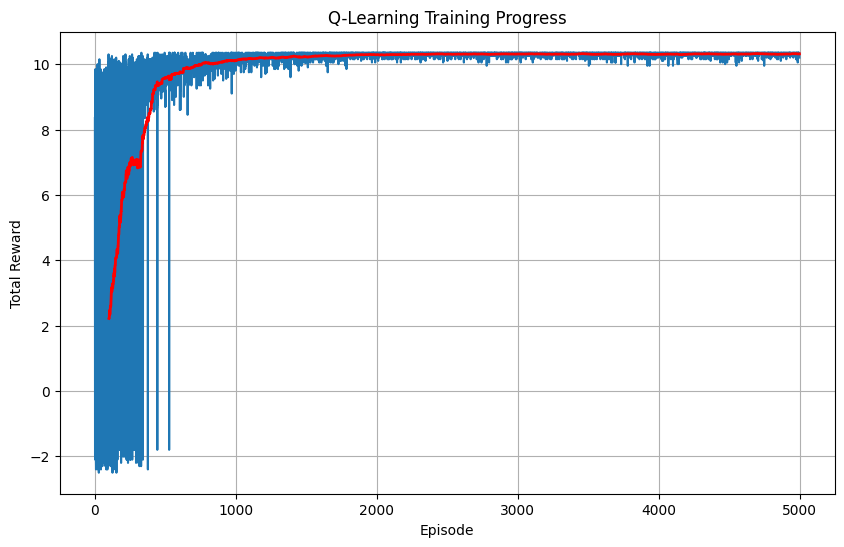

In [4]:
# --- Training Setup ---
env = GridWorldEnv(size=5)
agent = QLearningAgent(env)

num_episodes = 5000
max_steps_per_episode = 50
rewards_history = []

# Define the single, fixed goal for training
TRAINING_GOAL = (env.size - 1, env.size - 1)
env.set_goal(TRAINING_GOAL)

print(f"Starting Q-learning training for goal: {TRAINING_GOAL}...")

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    
    for step in range(max_steps_per_episode):
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        
        agent.update_q_table(state, action, reward, next_state)
        
        state = next_state
        total_reward += reward
        if done: break
            
    agent.decay_epsilon()
    rewards_history.append(total_reward)
    
    if (episode + 1) % 500 == 0:
        print(f"Episode {episode+1}/{num_episodes}, Avg Reward (last 100): {np.mean(rewards_history[-100:]):.2f}")

print("\nQ-learning training finished!")

# Plotting the training progress
plt.figure(figsize=(10, 6))
plt.plot(rewards_history)
# Plot a smoothed version to see the trend more clearly
smoothing_window = 100
smoothed_rewards = [np.mean(rewards_history[i-smoothing_window:i]) for i in range(smoothing_window, len(rewards_history))]
plt.plot(range(smoothing_window, len(rewards_history)), smoothed_rewards, color='red', linewidth=2)
plt.title('Q-Learning Training Progress')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()


## 5. Evaluation and Comparison

This is the most important part. We will now evaluate our specialist Q-agent in two scenarios and discuss the results in the context of meta-learning.

1.  **Test on the Trained Goal:** How well does it perform on the task it was trained for?
2.  **Test on a New, Unseen Goal:** How well does it perform when the task changes? Can it adapt?

--- Evaluating Q-Learning Agent ---

Testing on the TRAINED goal: (4, 4)


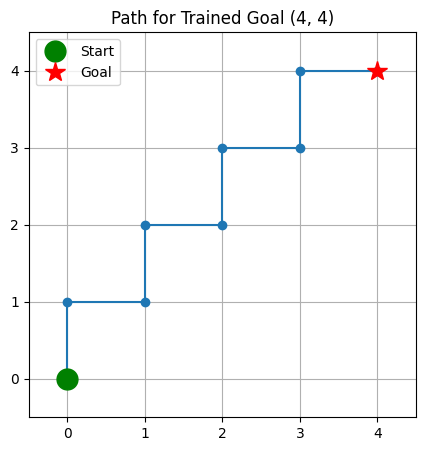


Testing on a NEW, UNSEEN goal: (4, 0)


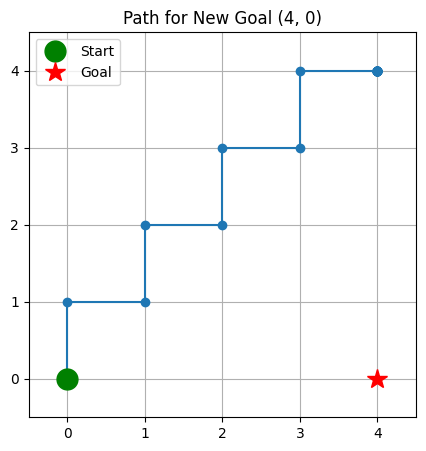

In [5]:
def test_agent(agent, env, goal, title):
    env.set_goal(goal)
    state = env.reset()
    path = [state]
    done = False
    
    # During testing, we turn off exploration (epsilon=0)
    agent.epsilon = 0
    
    for _ in range(50):
        action = agent.choose_action(state)
        state, _, done = env.step(action)
        path.append(state)
        if done: break
            
    # Plot the path
    path = np.array(path)
    plt.figure(figsize=(5, 5))
    plt.plot(path[:, 0], path[:, 1], marker='o', linestyle='-')
    plt.plot(path[0, 0], path[0, 1], 'go', markersize=15, label='Start')
    plt.plot(goal[0], goal[1], 'r*', markersize=15, label='Goal')
    plt.grid(True)
    plt.xlim(-0.5, env.size - 0.5)
    plt.ylim(-0.5, env.size - 0.5)
    plt.title(title)
    plt.legend()
    plt.show()

print("--- Evaluating Q-Learning Agent ---")

# 1. Test on the goal it was trained on
print(f"\nTesting on the TRAINED goal: {TRAINING_GOAL}")
test_agent(agent, env, TRAINING_GOAL, f"Path for Trained Goal {TRAINING_GOAL}")

# 2. Test on a new, unseen goal
NEW_GOAL = (env.size - 1, 0)
print(f"\nTesting on a NEW, UNSEEN goal: {NEW_GOAL}")
test_agent(agent, env, NEW_GOAL, f"Path for New Goal {NEW_GOAL}")


## 6. Conclusion: Q-Learning vs. Meta-Learning

The results from the evaluation cell clearly demonstrate the fundamental trade-off:

**Q-Learning (The Specialist):**
- **Performance:** After extensive training, the Q-learning agent becomes an expert at solving the *single task* it was trained on. Its path to the trained goal is highly optimal.
- **Adaptability:** It has **zero adaptability**. When the goal changes, its Q-table is useless. It has learned a fixed policy for a fixed problem and cannot generalize. It would need to be completely retrained from scratch to solve the new maze.

**MAML (The Fast Learner):**
- **Performance:** The initial meta-policy from MAML is not an expert at any single task. Its first attempt at a new maze might be clumsy (like the "Path BEFORE Adaptation" plot in the MAML notebook).
- **Adaptability:** This is its superpower. After just a *few* attempts (the inner loop updates), it can adapt its policy and find an efficient path to a **new, unseen goal**. It was trained not to solve one maze, but to be good at *learning to solve* any maze from its training distribution.

**When to use which?**
- Use **Q-Learning** when you have a stable, unchanging environment and you need the absolute best performance for that one task (e.g., mastering a game like Chess or Go).
- Use **Meta-Learning** when you expect the environment or task to change, and you need an agent that can adapt quickly with very little new data (e.g., a robot navigating different houses, or a system personalizing recommendations for new users).